## Gravitational Wave Signal Data Analysis Project  
### Simulating and Identifying Binary Neutron Star Chirp Signals  through analysis of data from LIGO - The Laser Interferometer Gravitational-Wave Observatory
 (Rearranged and simplified from my research codes for demonstration purposes)


## Signal Simulation and Noise Analysis

In [ ]:
import numpy as np
import scipy
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

In [5]:
## Parameters
# Neutron star masses (solar masses)
m1 = 1.46  # Primary mass
m2 = 1.27  # Secondary mass
dL = 40    # Distance to source (megaparsecs)

# Sky coordinates of the source (R.A. and Dec.)
raHourMinSec = (13, 9, 48.08) 
decDegMinSec = (-23, 22, 53.3) 

def celestial_coordinates(raHourMinSec, decDegMinSec):
    """Convert astronomical coordinates to detector-friendly unit2. Detector Response Simulation
LIGO's antennas have directional sensitivity. We calculate the "antenna pattern" for the Hanford detector (H1):s"""
    def right_ascension(h, m, s):
        return (h + m/60 + s/3600) * 15  # Convert hours to degrees
    
    def declination(d, m, s):
        return (d + m/60 + s/3600) * np.pi/180  # Convert degrees to radians
    
    return right_ascension(*raHourMinSec), declination(*decDegMinSec)

ra, dec = celestial_coordinates(raHourMinSec, decDegMinSec)
phi = 0  # Polarization angle
t_gps = 1187008882.4  # GPS timestamp of event

### 1. Generating the Gravitational Waveform
We use PyCBC's waveform model for binary neutron stars. (A theoretical waveform model is required for the simulation of a detection.)

In [3]:
# Generate time-domain waveform
sample_rate = 2048  # LIGO's sampling frequency (Hz)
hp, hc = get_td_waveform(
    approximant="IMRPhenomPv2",  # Waveform model for neutron stars
    mass1=m1,
    mass2=m2,
    distance=dL,
    delta_t=1.0/sample_rate,
    f_lower=40  # Start frequency (Hz) - LIGO's sensitive range
)

### 2. Detector Response Simulation
LIGO's antennas have directional sensitivity. We calculate the "antenna pattern" for the Hanford detector (H1). Combined with the theoretical data, we obtain the signal data we would detect.

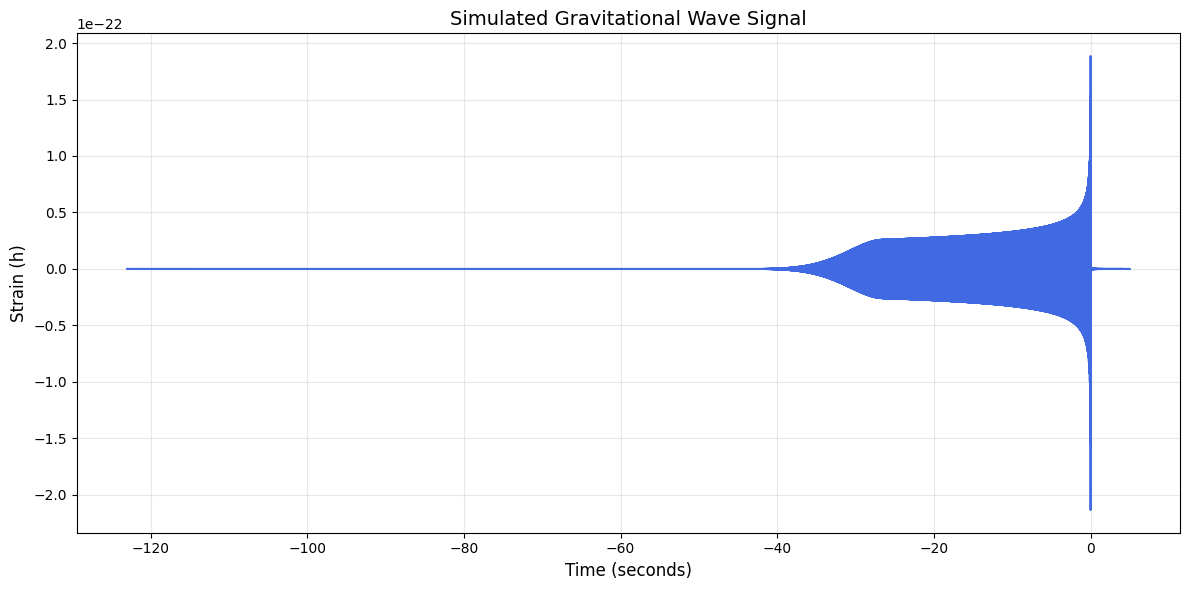

In [4]:
from pycbc.detector import Detector

H1 = Detector("H1")  # Hanford, Washington observatory

# Calculate detector response factors (depend on sky location)
fp, fc = H1.antenna_pattern(ra, dec, phi, t_gps)

# Combine polarization components
signal = fp*hp + fc*hc  # Total strain observed by H1

# Plot the simulated signal
plt.figure(figsize=(12, 6))
plt.plot(signal.sample_times, signal, color='royalblue')
plt.title("Simulated Gravitational Wave Signal", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Strain (h)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Realistic Noise Generation
LIGO's noise is frequency-dependent. We use the design PSD (Power Spectral Density) for Advanced LIGO. Data cleaned so that frequencies that are too low are ignored.

In [5]:
from pycbc.psd import aLIGODesignSensitivityP1200087
import pycbc.noise

# Create PSD model
psd = aLIGODesignSensitivityP1200087(
    length=len(signal)//2 + 1,
    delta_f=1.0/signal.duration,
    low_freq_cutoff=10  # Ignore frequencies below 10 Hz
)

# Generate colored Gaussian noise
noise = pycbc.noise.noise_from_psd(
    length=len(signal),
    delta_t=1.0/sample_rate,
    psd=psd,
    seed=42  # Fixed seed for reproducibility
)
noise.start_time = signal.start_time

# Create noisy data stream
data = noise + signal  # Realistic observation

### 4. Signal Visualization in Noise
In actual detection, the noise is significantly larger in magnitude than the signal, making detection a challenge.

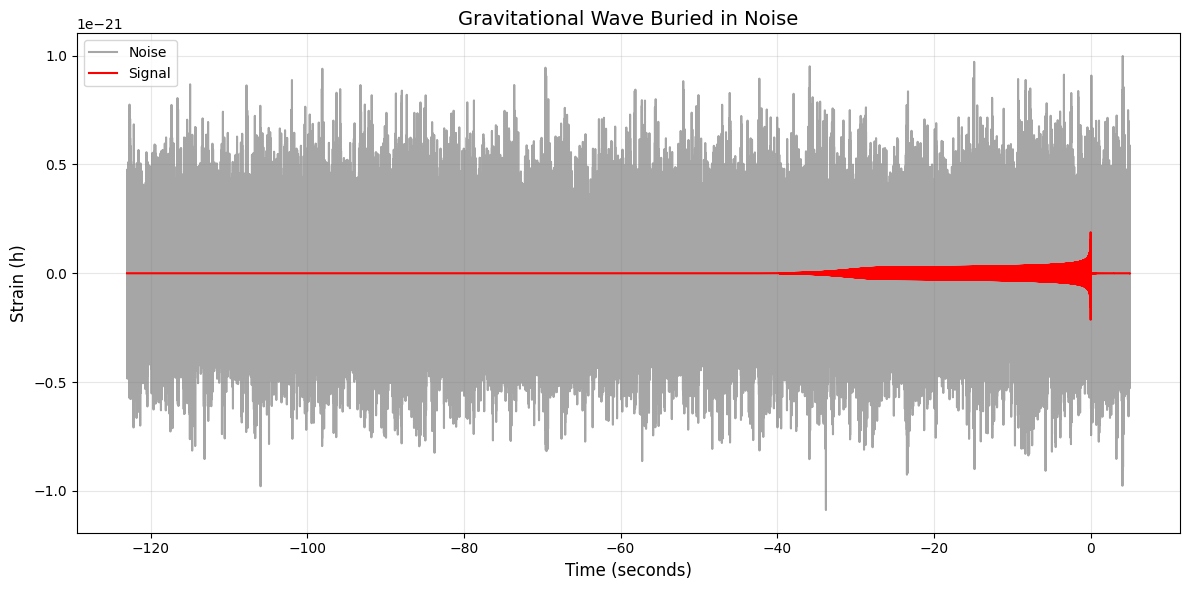

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data.sample_times, noise, color='gray', alpha=0.7, label="Noise")
plt.plot(data.sample_times, signal, color='red', linewidth=1.5, label="Signal")
plt.title("Gravitational Wave Buried in Noise", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Strain (h)", fontsize=12)
plt.legend()
#plt.ylim(-1e-22, 1e-22)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Data Whitening and Spectrogram Analysis
Whitening the data helps reveal hidden signals. Data whitening is a preprocessing technique that transforms a dataset so that its noise components have zero mean, unit variance, and no correlation between frequencies. This "flattens" the noise spectrum, making it easier to detect signals buried in colored (frequency-dependent) noise.

- Gravitational wave detectors like LIGO have noise that varies with frequency e.g., more noise at low frequencies.

- Chirp from merging neutron stars are relatively low frequencies (20-500 Hz).

- Whitening removes this frequency dependence, making signals (like the chirp from merging neutron stars) stand out more clearly.

- The whitened spectrum is obtained by:
### $$\tilde x_{white}(f)=\frac{\tilde x(f)}{\sqrt{\frac{1}{2\Delta f}  S(f)}}$$
    - $\tilde x(f)$ is the time-dependent data.
    - $\Delta f$ is the frequency resolution (1/$\Delta t$)
    - $S(f)$ is the power spectral density (PSD)

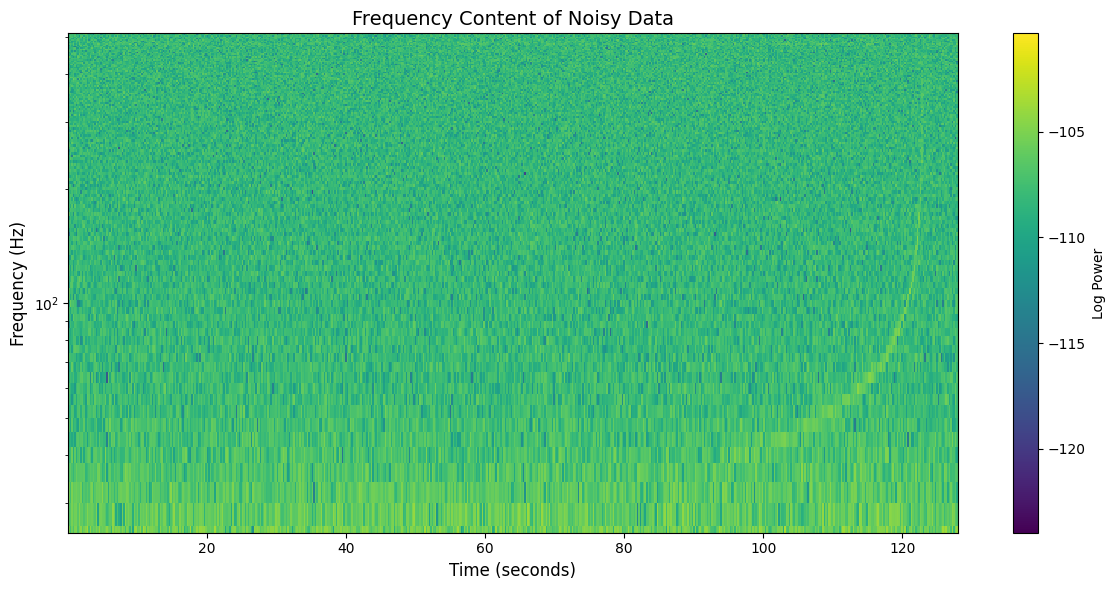

In [35]:
low_freq_cutoff=10
"""Whitens data using the PSD, avoiding divisions by zero."""
# Convert PSD to numpy array and get frequency resolution
psd_array = np.array(psd)
delta_f = psd.delta_f  # Frequency resolution (Hz)
freqs = psd.sample_frequencies  # Frequency array

# Compute FFT of the data
freq_domain = np.fft.rfft(data.numpy())  # Ensure data is a numpy array

# Whitening: Divide by sqrt(PSD * 2 * delta_f)
white_freq = np.zeros_like(freq_domain, dtype=np.complex128)
denominator = np.sqrt(psd_array[valid_freq_mask] * 2 * delta_f)
white_freq[valid_freq_mask] = freq_domain[valid_freq_mask] / denominator

# Inverse FFT to get whitened time series
white_data = np.fft.irfft(white_freq, n=len(data))

# Apply whitening
white_data = whiten_data(data, psd, sample_rate=sample_rate, low_freq_cutoff=10)

# Compute spectrogram
freq, time, Sxx = scipy.signal.spectrogram(data, sample_rate, nperseg=512)

plt.figure(figsize=(12, 6))
plt.pcolormesh(time, freq, np.log(Sxx), cmap='viridis', shading='auto')
plt.title("Frequency Content of Noisy Data", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.colorbar(label="Log Power")
plt.ylim(25,512)
plt.yscale('log')
plt.tight_layout()
plt.show()

As we can see, the bright line indicates a signal with an exponential increase in frequency with time. We call it a "chirp", analogous to the sound of a chirp from a bird.